In [1]:
# import resources
import numpy as np
import torch

# random seed (for reproducibility)
seed = 1
# set random seed for numpy
np.random.seed(seed)
# set random seed for pytorch
torch.manual_seed(seed)

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# convert data to Tensors
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                            download=False, transform=transform)

test_data = datasets.MNIST(root='data', train=False, 
                           download=False, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size, 
                                           num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size=batch_size, 
                                          num_workers=num_workers)

In [41]:
# it will also be relevant, in this model, to see if I can train on gpu
TRAIN_ON_GPU = torch.cuda.is_available()

if(TRAIN_ON_GPU):
    print('Training on GPU!')
else:
    print('Only CPU available')

Training on GPU!


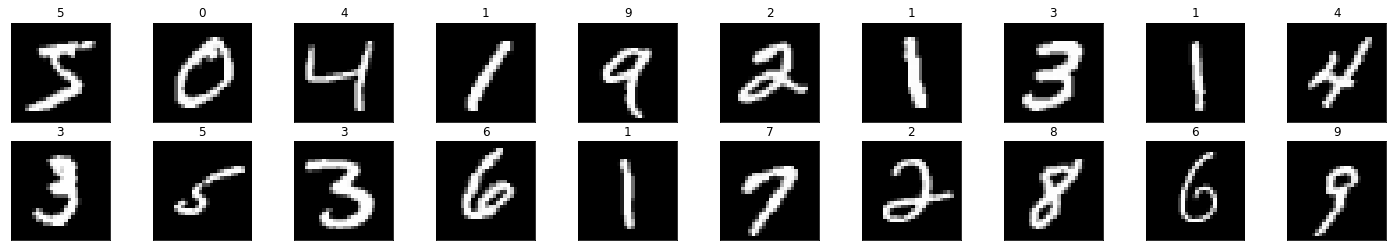

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

In [4]:
# batchsize:20.  in_channel:1. 
images.shape, labels.shape

((20, 1, 28, 28), torch.Size([20]))

In [5]:
import torch.nn as nn
import torch.nn.functional as F

# Encoder

编码器由一系列层组成，负责将 28 x 28 MNIST 图像作为输入并学习将其编码为 16 维输出向量。

<img src='assets/capsule_encoder.png' width=70%/>

(Image from [the original Capsule Network paper](https://arxiv.org/pdf/1710.09829.pdf))

## First Layer: Convolutional Layer

我们编码器的第一层是卷积层，它将学习在给定的输入图像中提取特征，如边缘。 
> In the original paper, this first convolutional layer has a `depth=256`, and uses a `kernel_size=9`, `stride=1`, and `padding=0`. This also calls for a `ReLu` activation on the outputs.

因此，给定一个输入 MNIST 图像，这个卷积层将创建 256 个过滤图像的堆栈。

For a 28x28 input image, a 9x9 kernel will not be able to perfectly overlay on the edges pixels of an image and, without any padding, I'll actually lose a border of 4 pixels on *each* side of the image as I filter it. So, for an input of size `(batch_size, 28, 28, 1)`, I'll get an output, convolutional layer with the dimensions `(batch_size, 20, 20, 256)`. And `batch_size` is just the number of input images that are processed in a batch; defined above in the `DataLoader` as `20`.

In [6]:
class ConvLayer(nn.Module):
    
    def __init__(self, in_channels=1, out_channels=256):
        '''Constructs the ConvLayer with a specified input and output size.
           param in_channels: input depth of an image, default value = 1
           param out_channels: output depth of the convolutional layer, default value = 256
           '''
        super(ConvLayer, self).__init__()

        # defining a convolutional layer of the specified size
        self.conv = nn.Conv2d(in_channels, out_channels, 
                              kernel_size=9, stride=1, padding=0)

    def forward(self, x):
        '''Defines the feedforward behavior.
           param x: the input to the layer; an input image
           return: a relu-activated, convolutional layer
           '''
        # 将 ReLu 激活应用于 conv 层的输出
        features = F.relu(self.conv(x)) # will have dimensions (batch_size, 20, 20, 256)
        return features

In [7]:
cnn = ConvLayer()
for batch_i, (images, target) in enumerate(train_loader):
    output = cnn(images)

In [8]:
output.shape

torch.Size([20, 256, 20, 20])

## Second Layer: Primary Capsules

这一层由 8 个“初级”胶囊组成，之所以这样称呼，是因为它们是胶囊的第一层。 它们将先前定义的卷积层的输出作为输入并产生一组输出向量。 本质上，每个胶囊负责生成在前一个卷积层中检测到的特征的加权组合。

根据论文，要获得一个胶囊的输出：
>* 定义一个具有`depth=32`, `kernel_size=9`, `**stride=2**`, and `padding=0` 的卷积层，并将其应用于上一层的特征。
* 通过将卷积层应用于大小为`(batch_size, 20, 20, 256)`, I will get a `(batch_size, 6, 6, 32)` Tensor as output for each of the 8 capsules. 
* I'll **reshape** this into an output vector using `.view(batch_size, 32*6*6, 1)`, for each of our 8 capsules and then stack those vectors.对于我们的 8 个胶囊中的每一个，我将使用 `.view(batch_size, 32*6*6, 1)` 将其**重塑**成一个输出向量，然后堆叠这些向量。
* Finally, I'll **squash** all of these vector; this is a nonlinear normalization step that forces the magnitude of the vectors to be in the range 0-1. 这是一个非线性归一化步骤，强制向量的大小在 0-1 的范围内。

#### A note on calculating dimensions

You may be wondering how I got from 20x20 to 6x6.

Again, I'm creating a border of 4 pixels on each side with a kernel_size of 9. So, I'll go from an x-y size of 20 - 4 on *all* sides to a size of 12. Then, with a `stride=2`, I'm efectively downsampling the previous inputs by a factor of 2, so I go from an x-y size of 12, divided by 2, to get an x-y size of 6. And you can read more about these precise output dimension calculations [at this Stanford cs231n page](http://cs231n.github.io/convolutional-networks/#conv) in the section on **spatial arrangement**.

### Squashing

> The magnitude of an output, capsule vector is a value between 0 and 1 that indicates the probability that a visual part (eyes, nose, etc.) exists and has been detected in an image. 输出的大小，胶囊向量是一个介于 0 和 1 之间的值，表示视觉部分（眼睛、鼻子等）存在并在图像中被检测到的概率。

To get this probability value, I define a nonlinear function `squash` that calculates a certain capsule's normalized, vector output using the following equation. 为了获得这个概率值，我定义了一个非线性函数 `squash`，它使用以下等式计算某个胶囊的归一化向量输出。

$$ v_j = \frac{||\ s_j^2\ ||\ s_j }{1 + ||\ s_j^2\ ||\ s_j } $$

$v_j$ 是我要计算的值，胶囊 $j$ 的归一化向量输出。而 $s_j$ 是那个胶囊的总输入；来自层 * 下方 * 胶囊 $j$ 中的胶囊的所有输出向量的加权和。对于除主要胶囊层之外的所有层，您可以将加权输入视为较小的*部分*的数量，这些部分认为它们是更大整体的一部分。这个想法是，如果你在一层中检测到鼻子和眼睛，有一定的概率（向量的大小），这就是下一层存在更大脸的证据。

> `squash` 函数是单个胶囊的加权输入的非线性函数。 它确保 $v_j$ 的大小是一个介于 0 和 1 之间的值。

#### ModuleList

Below, I'm taking advantage of PyTorch's [nn.ModuleList](https://pytorch.org/docs/stable/nn.html#modulelist) container to create a list of convolutional layers that is as long as my number of passed in capsules, `num_capsules`.

In [9]:
class PrimaryCaps(nn.Module):
    
    def __init__(self, num_capsules=8, in_channels=256, out_channels=32):
        '''Constructs a list of convolutional layers to be used in 
           creating capsule output vectors.
           param num_capsules: number of capsules to create
           param in_channels: input depth of features, default value = 256
           param out_channels: output depth of the convolutional layers, default value = 32
           '''
        super(PrimaryCaps, self).__init__()

        # creating a list of convolutional layers for each capsule I want to create
        # all capsules have a conv layer with the same parameters
        # num_capsules = 8
        # [batch, 20, 20, 256]-->[batch, 20, 20, 32]*8
        # 将256个特征变成8个特征，即8个胶囊
        self.capsules = nn.ModuleList([
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                      kernel_size=9, stride=2, padding=0)
            for _ in range(num_capsules)])
    
    def forward(self, x):
        '''Defines the feedforward behavior.
           param x: the input; features from a convolutional layer
           return: a set of normalized, capsule output vectors
           '''
        # get batch size of inputs
        batch_size = x.size(0)
        # reshape convolutional layer outputs to be (batch_size, vector_dim=1152, 1)
        # (batch_size, vector_dim=1152, 1)
        # 将每一个胶囊打平成一个矩阵，一共就有8个(batch, 1152, 1)
        u = [capsule(x).view(batch_size, 32 * 6 * 6, 1) for capsule in self.capsules]
        # 堆叠输出向量 u，每个胶囊一个
        u = torch.cat(u, dim=-1)
        # 压缩向量堆栈
        u_squash = self.squash(u)
        return u_squash
    
    # 将每个胶囊的输出限制在[0, 1]，即为眼睛或者鼻子的概率
    def squash(self, input_tensor):
        '''Squashes an input Tensor so it has a magnitude between 0-1.
           param input_tensor: a stack of capsule inputs, s_j
           return: a stack of normalized, capsule output vectors, v_j
           '''
        squared_norm = (input_tensor ** 2).sum(dim=-1, keepdim=True)
        scale = squared_norm / (1 + squared_norm) # normalization coeff
        output_tensor = scale * input_tensor / torch.sqrt(squared_norm)    
        return output_tensor

In [10]:
cnn = ConvLayer()
caps = PrimaryCaps()
for batch_i, (images, target) in enumerate(train_loader):
    input_cnn = cnn(images)
    output = caps(input_cnn)

In [11]:
output.shape

torch.Size([20, 1152, 8])

In [12]:
output

tensor([[[ 9.8454e-04, -1.4256e-02,  3.5393e-03,  ...,  5.3772e-03,
           1.0985e-02,  1.3139e-03],
         [ 1.4962e-02, -9.3500e-03,  1.6435e-02,  ...,  2.2362e-02,
           2.4200e-02,  1.4075e-02],
         [ 3.4626e-02, -1.4226e-02,  1.0961e-02,  ...,  2.5661e-02,
           5.8973e-02,  7.9338e-03],
         ...,
         [ 3.1494e-02,  2.8321e-02,  3.6488e-02,  ..., -5.4702e-02,
           5.4916e-02, -6.4734e-02],
         [ 4.2085e-02,  2.3796e-02,  1.7544e-03,  ..., -3.5500e-02,
           2.8331e-02, -4.5619e-02],
         [ 4.9432e-02, -9.7282e-04,  1.9644e-02,  ..., -9.1058e-03,
          -5.0853e-03, -5.1714e-02]],

        [[ 1.8421e-03, -1.0613e-02, -1.3547e-02,  ...,  2.5333e-02,
           2.6851e-02, -2.2705e-03],
         [-6.7913e-04, -4.9303e-03, -3.7359e-04,  ...,  3.3628e-02,
           2.9396e-02, -2.3923e-02],
         [-2.2408e-02, -5.4785e-03, -8.9064e-03,  ...,  2.4195e-02,
           3.1232e-02, -2.5962e-02],
         ...,
         [ 3.0289e-02,  1

## Third Layer: Digit Capsules

这一层由 10 个“数字”胶囊组成，每个数字类别 0-9。 每个胶囊将上面的 8 个主要胶囊产生的一批 1152 维向量作为输入。

> 这是网络编码器部分的最后一层，这 10 个胶囊中的每一个都负责产生一个 16 维的输出向量。

换句话说，该层从 1152 维的输入向量空间映射到 16 维的输出向量空间。 这也是您将看到 **动态路由** 实现的地方。

[batch, 1152, 8, 1]：每个胶囊的纬度是[1152, 1]，一共有8个胶囊
将每个胶囊乘权重矩阵

## Dynamic Routing

动态路由是在一层胶囊的输出和下一层胶囊的输入之间寻找*最佳*连接的过程。 它允许胶囊相互通信并确定数据如何通过它们！
> 无论胶囊网络看到什么样的输入图像，动态路由都可以确保“PrimaryCaps”层中的 *child* 胶囊的输出将被发送到这个“DigitCaps”层中最相关的 *parent* 胶囊。

### Coupling Coefficients

当胶囊网络初始化时，主胶囊不确定它们的输出应该去哪个父胶囊（数字胶囊）。 事实上，每个主胶囊都以一个**可能的父母**列表开始，这些**可能是下一层中的*所有*父胶囊。

> 这种可能的关系由一个叫做**耦合系数**的值表示，**c**，这是某个胶囊的输出应该去下一层的父胶囊的概率。

耦合系数的示例，写在子节点与其可能的父节点之间的连接线上，如下图所示。 具有两个可能的父节点的子节点开始时两者的耦合系数相同：0.5。

<img src='assets/coupling_coeff.png' width=30%/>

(Image from [my blog post on Capsule Nets](https://cezannec.github.io/Capsule_Networks/))

所有可能的父母的耦合系数可以被描绘成一个离散的概率分布。 在一个子胶囊和所有可能的父胶囊之间的所有连接中，耦合系数之和应为 1。


### Routing by Agreement

动态路由是更新这些耦合系数的迭代过程。 胶囊 $i$ 与其上层所有胶囊 $j$ 之间的耦合系数 $c_{ij}$ 总和为 1，并由路由 **softmax** 函数确定，其初始对数为 $b_{ij}$ 是胶囊 $i$ *应该* 耦合到胶囊 $j$ 的对数先验概率。 $b_{ij}$ 与主胶囊（长度为 1152）和数字胶囊（10）的输出向量之间可能存在的联系一样多。

$$c_{ij} = \frac{e^{\ b_{ij}}}{\sum_{k}\ {e^{\ b_{ik}}}} $$

在网络训练期间执行的更新过程对于单个胶囊如下：

> 1. 每个子胶囊都会输出一些向量 $u$，其大小表示部件的*存在*，其方向表示部件的广义姿态。
2. 对于每个可能的父级，子胶囊计算一个预测向量 $\hat{u}$，它是其输出向量 $u$ 乘以权重矩阵 $W$ 的函数。 $W$ 代表空间中的线性变换——就像一些旋转和平移——$\hat{u}$ 可以被认为是对父胶囊输出向量的位置和方向的预测。
3. 如果预测向量 $\hat{u}$ 与父胶囊输出向量 $v$ 有一个很大的**点积**，那么这些向量被称为 **agree** 和耦合系数*那个*父母和子胶囊之间的增加，而该子胶囊和*所有其他*父母之间的耦合系数减小。
4. 父输出向量 $v$ 和预测向量 $\hat{u}$ 之间的点积被称为胶囊 **agreement** 的形式度量 $a$。
5. 此协议会影响信息在网络中移动时的加权方式。
6. 新的 $b_{ij}$ 计算为 *当前* $b_{ij}$ 加上 $a$。
7. 新的耦合系数 $c_{ij}$ 使用上述 softmax 公式和新的 $b_{ij}$ 计算。
$$\hat{u} = W u $$

$$a = v \cdot u $$

$$b_{ij} = b_{ij} + a $$



这有时被称为**自上而下的反馈**；来自后一层父胶囊输出的反馈。

**一个典型的训练过程可能包括*三次*一致性迭代，其中$b_{ij}$被更新（通过步骤1-7），总共3次以获得将用于计算的最终耦合系数最终输出，$v_j$.**

> 子胶囊和父胶囊之间的高耦合系数会增加子胶囊对父胶囊的贡献，从而*进一步*对齐它们的两个输出向量并使它们的一致性点积更大！这称为**路由协议**。

我应该注意到，与之前的 `PrimaryCaps` 层相比，这个计算改变了我计算数字胶囊 $s_j$ 总输入的方式。在`DigitCaps`的情况下，$s_j$是来自层*下面*的胶囊的所有输入向量的总和，$u$乘以权重矩阵$W$，换句话说$W u = \hat{u }$, *also* 乘以耦合系数。第一层胶囊只将卷积特征视为输入，这些特征没有为路由和使用耦合系数提供足够的信息。

$$ s_j = \sum{c_{ij} \ \hat{u}}$$

In [13]:
import helpers # to get transpose softmax function

# dynamic routing
def dynamic_routing(b_ij, u_hat, squash, routing_iterations=3):
    '''Performs dynamic routing between two capsule layers.
       param b_ij: initial log probabilities that capsule i should be coupled to capsule j
       param u_hat: input, weighted capsule vectors, W u
       param squash: given, normalizing squash function
       param routing_iterations: number of times to update coupling coefficients
       return: v_j, output capsule vectors
       '''    
    # update b_ij, c_ij for number of routing iterations
    for iteration in range(routing_iterations):
        # softmax calculation of coupling coefficients, c_ij
        # c_ij: torch.Size([10, 20, 1152, 1, 16])
        c_ij = helpers.softmax(b_ij, dim=2)

        # calculating total capsule inputs, s_j = sum(c_ij*u_hat)
        # s_j: torch.Size([10, 20, 1, 1, 16])
        s_j = (c_ij * u_hat).sum(dim=2, keepdim=True)

        # squashing to get a normalized vector output, v_j
        # v_j: torch.Size([10, 20, 1, 1, 16])
        v_j = squash(s_j)

        # if not on the last iteration, calculate agreement and new b_ij
        if iteration < routing_iterations - 1:
            # agreement
            a_ij = (u_hat * v_j).sum(dim=-1, keepdim=True)
            
            # new b_ij
            b_ij = b_ij + a_ij
    
    return v_j # return latest v_j

## Digit Capsules

Now that I've defined the dynamic routing process, I can complete the `DigitCaps` class.
* This layer is composed of 10 "digit" capsules, one for each of our digit classes 0-9. 
* Each capsule takes, as input, a batch of 1152-dimensional vectors produced by our 8 primary capsules, above. 
* Each of these 10 capsules is responsible for producing a **16-dimensional** output vector.

I suggest you train on GPU for a faster training time, and I'm checking for the availability of a GPU device, below.

In [14]:
class DigitCaps(nn.Module):
    
    def __init__(self, num_capsules=10, previous_layer_nodes=32*6*6, 
                 in_channels=8, out_channels=16):
        '''Constructs an initial weight matrix, W, and sets class variables.
           param num_capsules: number of capsules to create
           param previous_layer_nodes: dimension of input capsule vector, default value = 1152
           param in_channels: number of capsules in previous layer, default value = 8
           param out_channels: dimensions of output capsule vector, default value = 16
           '''
        super(DigitCaps, self).__init__()

        # setting class variables
        self.num_capsules = num_capsules
        self.previous_layer_nodes = previous_layer_nodes # vector input (dim=1152)
        self.in_channels = in_channels # previous layer's number of capsules

        # starting out with a randomly initialized weight matrix, W
        # these will be the weights connecting the PrimaryCaps and DigitCaps layers
        self.W = nn.Parameter(torch.randn(num_capsules, previous_layer_nodes, 
                                          in_channels, out_channels))

    def forward(self, u):
        '''Defines the feedforward behavior.
           param u: the input; vectors from the previous PrimaryCaps layer
           return: a set of normalized, capsule output vectors
           '''
        
        # adding batch_size dims and stacking all u vectors
        # u 为上一层的输出
        # u: torch.Size([1, 20, 1152, 1, 8])
        u = u[None, :, :, None, :]
        
        # 4D weight matrix
        # W: torch.Size([10, 1, 1152, 8, 16])
        W = self.W[:, None, :, :, :]
        
        # calculating u_hat = W*u
        # u_hat: torch.Size([10, 20, 1152, 1, 16])
        u_hat = torch.matmul(u, W)

        # getting the correct size of b_ij
        # setting them all to 0, initially
        # b_ij初始化都为0
        # b_ij: torch.Size([10, 20, 1152, 1, 16])
        b_ij = torch.zeros(*u_hat.size())
        
#         # moving b_ij to GPU, if available
#         if TRAIN_ON_GPU:
#             b_ij = b_ij.cuda()

        # update coupling coefficients and calculate v_j
        v_j = dynamic_routing(b_ij, u_hat, self.squash, routing_iterations=3)

        return v_j # return final vector outputs
    
    
    def squash(self, input_tensor):
        '''Squashes an input Tensor so it has a magnitude between 0-1.
           param input_tensor: a stack of capsule inputs, s_j
           return: a stack of normalized, capsule output vectors, v_j
           '''
        # same squash function as before
        squared_norm = (input_tensor ** 2).sum(dim=-1, keepdim=True)
        scale = squared_norm / (1 + squared_norm) # normalization coeff
        output_tensor = scale * input_tensor / torch.sqrt(squared_norm)    
        return output_tensor

In [15]:
cnn = ConvLayer()
caps = PrimaryCaps()
digitCaps = DigitCaps()
for batch_i, (images, target) in enumerate(train_loader):
    input_cnn = cnn(images)
    caps_output = caps(input_cnn)
    digitCaps_output = digitCaps(caps_output)

In [16]:
input_cnn.shape, caps_output.shape, digitCaps_output.shape

(torch.Size([20, 256, 20, 20]),
 torch.Size([20, 1152, 8]),
 torch.Size([10, 20, 1, 1, 16]))

This completes the encoder portion of the model! Next, the decoder.

---
# Decoder 

解码器将“DigitCaps”层产生的 16 维向量视为输入。 在 `forward` 函数中，解码器识别“正确”的胶囊输出向量； 这个向量是所有十位胶囊输出中向量幅度最大的向量（回想一下，向量幅度对应于图像中某个部分的**存在**）。 然后，解码器对该向量进行上采样，将其解码为手写数字的重构图像。

> 解码器正在学习从胶囊输出向量到 784-dim 向量的映射，该向量可以被重塑为 28x28 重建图像。

<img src='assets/capsule_decoder.png' width=60% />

(Image from [the original Capsule Network paper](https://arxiv.org/pdf/1710.09829.pdf))

我希望这个重建的图像和原始的输入图像尽可能接近！ 所以，当我训练这个网络时，我会看看输入图像和这个解码器重建之间的区别； 任何差异（以欧几里德距离衡量）都将记录为损失。

#### Reconstruction Loss
稍后我将更详细地讨论网络损失。 现在，知道作者使用这种基于解码器的重建损失来鼓励数字胶囊学习编码有关原始输入图像内容的信息。

## Linear Layers

解码器由三个完全连接的线性层组成。 这些只是用 input_size 和 output_size 定义的。 第一层看到来自数字胶囊层的 10、16 维输出向量，并产生 `hidden_dim=512` 数量的输出。 下一个隐藏层只是将这个深度增加了 2，而第三个也是最后一个线性层产生了 784 个值的输出，可以将其重塑为 28x28 的图像！

隐藏层应用了 ReLu 激活，最后的输出层有一个 **sigmoid** 激活函数，以确保输出都是有效像素范围 0-1 内的所有值。

In [28]:
class Decoder(nn.Module):
    
    def __init__(self, input_vector_length=16, input_capsules=10, hidden_dim=512):
        '''Constructs an series of linear layers + activations.
           param input_vector_length: dimension of input capsule vector, default value = 16
           param input_capsules: number of capsules in previous layer, default value = 10
           param hidden_dim: dimensions of hidden layers, default value = 512
           '''
        super(Decoder, self).__init__()
        
        # calculate input_dim
        # 16*10=160
        input_dim = input_vector_length * input_capsules
        
        # define linear layers + activations
        self.linear_layers = nn.Sequential(
            # (160, 512)
            nn.Linear(input_dim, hidden_dim), # first hidden layer
            nn.ReLU(inplace=True),
            # (512, 1024)
            nn.Linear(hidden_dim, hidden_dim*2), # second, twice as deep
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim*2, 28*28), # can be reshaped into 28*28 image
            nn.Sigmoid() # sigmoid activation to get output pixel values in a range from 0-1
            )
        
    def forward(self, x):
        '''Defines the feedforward behavior.
           param x: the input; vectors from the previous DigitCaps layer
           return: two things, reconstructed images and the class scores, y
           '''
        # classes: torch.Size([20, 10])
        classes = (x ** 2).sum(dim=-1) ** 0.5
        classes = F.softmax(classes, dim=-1)
        
        # find the capsule with the maximum vector length
        # here, vector length indicates the probability of a class' existence
        _, max_length_indices = classes.max(dim=1)
        
        # create a sparse class matrix
        # sparse_matrix: torch.Size([10, 10])
        sparse_matrix = torch.eye(10) # 10 is the number of classes
#         if TRAIN_ON_GPU:
#             sparse_matrix = sparse_matrix.cuda()
        # get the class scores from the "correct" capsule
    # y: torch.Size([20, 10])
        y = sparse_matrix.index_select(dim=0, index=max_length_indices.data)
        
        # create reconstructed pixels
        # x: torch.Size([20, 10, 16])
        x = x * y[:, :, None]
        
        # flatten image into a vector shape (batch_size, vector_dim)
        # flattened_x: torch.Size([20, 160])
        flattened_x = x.contiguous().view(x.size(0), -1)
        
        # create reconstructed image vectors
        # reconstructions: torch.Size([20, 784])
        reconstructions = self.linear_layers(flattened_x)
        
        # return reconstructions and the class scores, y
        return reconstructions, y

In [27]:
cnn = ConvLayer()
caps = PrimaryCaps()
digitCaps = DigitCaps()
decoder = Decoder()
for batch_i, (images, target) in enumerate(train_loader):
    input_cnn = cnn(images)
    caps_output = caps(input_cnn)
    digitCaps_output = digitCaps(caps_output).squeeze().transpose(0,1)
    reconstructions, y = decoder(digitCaps_output)

classes: torch.Size([20, 10])
classes: tensor([[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000],
        [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000],
        [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000],
        [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000],
        [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000],
        [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000],
        [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000],
        [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000],
        [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000],
        [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.100

KeyboardInterrupt: 

In [29]:
cnn = ConvLayer()
caps = PrimaryCaps()
digitCaps = DigitCaps()
decoder = Decoder()
for batch_i, (images, target) in enumerate(train_loader):
    input_cnn = cnn(images)
    caps_output = caps(input_cnn)
    digitCaps_output = digitCaps(caps_output).squeeze().transpose(0,1)
    reconstructions, y = decoder(digitCaps_output)

In [30]:
input_cnn.shape, caps_output.shape, digitCaps_output.shape, reconstructions.shape, y.shape

(torch.Size([20, 256, 20, 20]),
 torch.Size([20, 1152, 8]),
 torch.Size([20, 10, 16]),
 torch.Size([20, 784]),
 torch.Size([20, 10]))

In [32]:
reconstructions, y

(tensor([[0.5030, 0.5009, 0.4918,  ..., 0.4871, 0.4972, 0.5084],
         [0.5030, 0.5009, 0.4918,  ..., 0.4871, 0.4972, 0.5084],
         [0.5030, 0.5009, 0.4918,  ..., 0.4871, 0.4972, 0.5084],
         ...,
         [0.5030, 0.5009, 0.4918,  ..., 0.4871, 0.4972, 0.5084],
         [0.5030, 0.5009, 0.4918,  ..., 0.4871, 0.4972, 0.5084],
         [0.5030, 0.5009, 0.4918,  ..., 0.4871, 0.4972, 0.5084]],
        grad_fn=<SigmoidBackward>),
 tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]

## Put it All Together 

Finally, I'll use *all* the layers I defined above to create a complete Capsule Network! Recall that the order of these layers is as follows:
1. ConvLayer
2. PrimaryCaps
3. DigitCaps
4. Decoder

And I specified all the default construction parameters.

<img src='assets/complete_caps_net.png' width=80%/>

(Image from [the original Capsule Network paper](https://arxiv.org/pdf/1710.09829.pdf))

In [33]:
class CapsuleNetwork(nn.Module):
    
    def __init__(self):
        '''Constructs a complete Capsule Network.'''
        super(CapsuleNetwork, self).__init__()
        self.conv_layer = ConvLayer()
        self.primary_capsules = PrimaryCaps()
        self.digit_capsules = DigitCaps()
        self.decoder = Decoder()
                
    def forward(self, images):
        '''Defines the feedforward behavior.
           param images: the original MNIST image input data
           return: output of DigitCaps layer, reconstructed images, class scores
           '''
        primary_caps_output = self.primary_capsules(self.conv_layer(images))
        caps_output = self.digit_capsules(primary_caps_output).squeeze().transpose(0,1)
        reconstructions, y = self.decoder(caps_output)
        return caps_output, reconstructions, y

In [34]:
# instantiate and print net
capsule_net = CapsuleNetwork()

print(capsule_net)

# # move model to GPU, if available 
# if TRAIN_ON_GPU:
#     capsule_net = capsule_net.cuda()

CapsuleNetwork(
  (conv_layer): ConvLayer(
    (conv): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  )
  (primary_capsules): PrimaryCaps(
    (capsules): ModuleList(
      (0): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (1): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (2): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (3): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (4): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (5): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (6): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (7): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
    )
  )
  (digit_capsules): DigitCaps()
  (decoder): Decoder(
    (linear_layers): Sequential(
      (0): Linear(in_features=160, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_featur

## Custom Loss

为了准备训练模型，我需要定义一个自定义损失。胶囊网络的损失是**两个**损失的加权组合：
1. **margin loss** 查看*所有*数字胶囊的输出并计算一个损失项，该损失项取决于所选的“正确”数字胶囊是否与正确的类标签匹配。
2. **重建损失**，查看原始输入图像以及它们与解码器生成的重建图像有何不同。

重建损失是一个简单的均方误差损失，我将其计算为“nn.MSELoss”。我在上面解释说这是一种[正则化方法](https://en.wikipedia.org/wiki/Regularization_(mathematics))。通过正则化，我的意思是它强制 16 个维度（在来自“DigitCaps”层的输出向量中）对应于有意义的内容信息；然后可用于*重建*原始图像的信息。重要的是要注意，原始 Capsule Net 论文的作者使用“0.0005”的系数对这种损失进行加权，因此它不会超过边际损失，这反映在下面的代码中。

所以，我真的想专注于描述这种新型损失，保证margin loss。
### Margin Loss

margin loss是一种分类损失，它基于来自“DigitCaps”层的输出向量的长度。回想一下，胶囊输出向量的大小是部件**存在**的度量。因此，对于手写数字的任何输入图像，我们希望*一个*特定的数字胶囊输出一个长向量，表明对一个特定数字类别的信心！该胶囊有时被称为“正确”胶囊。

保证margin loss使这个想法正式化；它表示如果图像中存在某个数字（在这种情况下为数字 0-9），则该数字胶囊的相应输出向量的平方长度不得小于 0.9。所以，如果我有一个 0 的输入图像，那么“正确”的、零检测的数字胶囊应该输出一个 0.9 或更大的向量！对于所有其他数字（在此示例中为 1-9），相应的DigitCaps输出向量的大小应为 0.1 或更小。

假设 $x$ 是类 $c$ (0-9) 的DigitCaps的输出向量。

现在，如果存在类 $c$ 的图像，则 $x$ 的大小应等于或大于 0.9。幅度是平方值的平方根，我将称该幅度为 $v_c = \sqrt{x^2}$，因此 $v_c >=0.9$。类似地，如果类 $c$ 数字在图像中*不存在*，则 $v_c <=0.1$。这些值将加在一起以计算总的保证margin loss。您可以在以下公式中看到。
$$L_c = T_c(\max[0, 0.9-v_c]) + \lambda (1-T_c)(\max[0, v_c-0.1])$$

其中 $T_c$ 是标签 0 或 1，指示数字胶囊向量是“正确”（1）还是不“正确”（0）。 而 $\lambda$ 是我们选择用于训练的值； 研究人员选择了“0.5”的值。 这些选择反映在下面的代码中，*和*我正在使用 ReLu 函数来获取 0 和另一个值的最大值。


这种损失将鼓励我们的模型使“正确”胶囊的索引与给定训练图像的真实类别标签相匹配。


In [35]:
class CapsuleLoss(nn.Module):
    
    def __init__(self):
        '''Constructs a CapsuleLoss module.'''
        super(CapsuleLoss, self).__init__()
        self.reconstruction_loss = nn.MSELoss(reduction='sum') # cumulative loss, equiv to size_average=False

    # 重构损失
    def forward(self, x, labels, images, reconstructions):
        '''Defines how the loss compares inputs.
           param x: digit capsule outputs
           param labels: 
           param images: the original MNIST image input data
           param reconstructions: reconstructed MNIST image data
           return: weighted margin and reconstruction loss, averaged over a batch
           '''
        batch_size = x.size(0)

        ##  calculate the margin loss   ##
        
        # get magnitude of digit capsule vectors, v_c
        v_c = torch.sqrt((x**2).sum(dim=2, keepdim=True))

        # calculate "correct" and incorrect loss
        # 计算正确的损失
        left = F.relu(0.9 - v_c).view(batch_size, -1)
        # 计算不正确的损失
        right = F.relu(v_c - 0.1).view(batch_size, -1)
        
        # sum the losses, with a lambda = 0.5
        margin_loss = labels * left + 0.5 * (1. - labels) * right
        margin_loss = margin_loss.sum()

        ##  calculate the reconstruction loss   ##
        images = images.view(reconstructions.size()[0], -1)
        reconstruction_loss = self.reconstruction_loss(reconstructions, images)

        # return a weighted, summed loss, averaged over a batch size
        return (margin_loss + 0.0005 * reconstruction_loss) / images.size(0)

### Specify Loss Function and [Optimizer](http://pytorch.org/docs/stable/optim.html)

I'm using the custom loss I defined above, and the paper uses an Adam optimizer.

In [38]:
import torch.optim as optim

# custom loss
criterion = CapsuleLoss()

# Adam optimizer with default params
optimizer = optim.Adam(capsule_net.parameters())

# 训练网络

下面的评论中描述了从一批数据中训练/学习的步骤：
1. 清除所有优化变量的梯度
2. 前向传递：通过将输入传递给模型来计算预测输出
3. 计算损失
4. Backward pass：计算损失相对于模型参数的梯度
5. 执行单个优化步骤（参数更新）
6. 更新平均训练损失

以下循环训练一定数量的 epoch 并间歇性地打印出训练损失； 看看训练损失的值如何随着时间的推移而减少。

In [44]:
def train(capsule_net, criterion, optimizer, 
          n_epochs, print_every=300):
    '''Trains a capsule network and prints out training batch loss statistics.
       Saves model parameters if *validation* loss has decreased.
       param capsule_net: trained capsule network
       param criterion: capsule loss function
       param optimizer: optimizer for updating network weights
       param n_epochs: number of epochs to train for
       param print_every: batches to print and save training loss, default = 100
       return: list of recorded training losses
       '''

    # track training loss over time
    losses = []

    # one epoch = one pass over all training data 
    for epoch in range(1, n_epochs+1):

        # initialize training loss
        train_loss = 0.0
        
        capsule_net.train() # set to train mode
    
        # get batches of training image data and targets
        for batch_i, (images, target) in enumerate(train_loader):

            # reshape and get target class
            target = torch.eye(10).index_select(dim=0, index=target)

#             if TRAIN_ON_GPU:
#                 images, target = images.cuda(), target.cuda()

            # zero out gradients
            optimizer.zero_grad()
            # get model outputs
            caps_output, reconstructions, y = capsule_net(images)
            # calculate loss
            loss = criterion(caps_output, target, images, reconstructions)
            # perform backpropagation and optimization
            loss.backward()
            optimizer.step()

            train_loss += loss.item() # accumulated training loss
            
            # print and record training stats
            if batch_i != 0 and batch_i % print_every == 0:
                avg_train_loss = train_loss/print_every
                losses.append(avg_train_loss)
                print('Epoch: {} \tTraining Loss: {:.8f}'.format(epoch, avg_train_loss))
                train_loss = 0 # reset accumulated training loss
        
    return losses

In [45]:
# training for 3 epochs
n_epochs = 3
losses = train(capsule_net, criterion, optimizer, n_epochs=n_epochs)

Epoch: 1 	Training Loss: 0.25416019
Epoch: 1 	Training Loss: 0.09693389
Epoch: 1 	Training Loss: 0.07481201
Epoch: 1 	Training Loss: 0.06084572
Epoch: 1 	Training Loss: 0.05957123
Epoch: 1 	Training Loss: 0.05459747
Epoch: 1 	Training Loss: 0.05172310
Epoch: 1 	Training Loss: 0.05036308
Epoch: 1 	Training Loss: 0.04830438
Epoch: 2 	Training Loss: 0.04344046
Epoch: 2 	Training Loss: 0.04022095
Epoch: 2 	Training Loss: 0.03585428
Epoch: 2 	Training Loss: 0.03471506
Epoch: 2 	Training Loss: 0.03600320
Epoch: 2 	Training Loss: 0.03425975
Epoch: 2 	Training Loss: 0.03495918
Epoch: 2 	Training Loss: 0.03393198
Epoch: 2 	Training Loss: 0.03403411
Epoch: 3 	Training Loss: 0.03042210
Epoch: 3 	Training Loss: 0.02857705
Epoch: 3 	Training Loss: 0.02728151
Epoch: 3 	Training Loss: 0.02735754
Epoch: 3 	Training Loss: 0.02774767
Epoch: 3 	Training Loss: 0.02689935
Epoch: 3 	Training Loss: 0.02885377
Epoch: 3 	Training Loss: 0.02836775
Epoch: 3 	Training Loss: 0.02779755


### 训练损失

绘制由“print_every”指定的间歇性记录的训练损失。

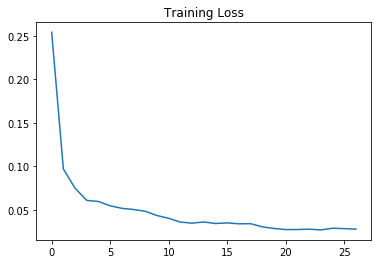

In [46]:
plt.plot(losses)
plt.title("Training Loss")
plt.show()

---
# 测试经过训练的网络

在这种情况下，有两种方法可以测试训练后的模型：查看它如何对测试数据进行分类，以及查看其重建与原始输入图像的比较。

## 测试数据
首先，我将在以前未见过的**测试数据** 上测试该模型并评估其性能。 对看不见的数据进行测试是检查我们的模型泛化良好的好方法。 在此分析中细化并查看此模型在每个类上的表现以及查看其整体损失和准确性也可能很有用。

In [61]:
def test(capsule_net, test_loader):
    '''打印给定胶囊网络的测试统计数据。
       参数capsule_net：训练好的胶囊网络
       参数 test_loader：测试数据加载器
       return：返回最后一批测试图像数据和对应的重建
       '''
    # 最开始初始化为0
    class_correct = list(0. for i in range(10))
    
    # 初始化为0
    class_total = list(0. for i in range(10))
    
    test_loss = 0 # loss tracking
    
    # 模型的结构
    capsule_net.eval() # eval mode

    for batch_i, (images, target) in enumerate(test_loader):
        # target: torch.Size([20, 10])
        target = torch.eye(10).index_select(dim=0, index=target)
        
        batch_size = images.size(0)

#         if TRAIN_ON_GPU:
#             images, target = images.cuda(), target.cuda()

        # forward pass: compute predicted outputs by passing inputs to the model
        caps_output, reconstructions, y = capsule_net(images)
        # calculate the loss
        loss = criterion(caps_output, target, images, reconstructions)

        # update average test loss 
        test_loss += loss.item()
        # convert output probabilities to predicted class
        _, pred = torch.max(y.data.cpu(), 1)
        _, target_shape = torch.max(target.data.cpu(), 1)

        # compare predictions to true label
        # correct: torch.Size([20])
        correct = np.squeeze(pred.eq(target_shape.data.view_as(pred)))
        
        # calculate test accuracy for each object class
        for i in range(batch_size):
            label = target_shape.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # avg test loss
    avg_test_loss = test_loss/len(test_loader)
    print('Test Loss: {:.8f}\n'.format(avg_test_loss))

    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                str(i), 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))
    
    # return last batch of capsule vectors, images, reconstructions
    return caps_output, images, reconstructions

In [50]:
# call test function and get reconstructed images
caps_output, images, reconstructions = test(capsule_net, test_loader)

class_correct: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
class_total: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
target: torch.Size([20, 10])
target: tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 

In [52]:
# call test function and get reconstructed images
caps_output, images, reconstructions = test(capsule_net, test_loader)

loss: tensor(0.0691, grad_fn=<DivBackward0>)
loss: tensor(0.0191, grad_fn=<DivBackward0>)
loss: tensor(0.0152, grad_fn=<DivBackward0>)
loss: tensor(0.0208, grad_fn=<DivBackward0>)
loss: tensor(0.0239, grad_fn=<DivBackward0>)
loss: tensor(0.0701, grad_fn=<DivBackward0>)
loss: tensor(0.0150, grad_fn=<DivBackward0>)
loss: tensor(0.0586, grad_fn=<DivBackward0>)
loss: tensor(0.0217, grad_fn=<DivBackward0>)
loss: tensor(0.0178, grad_fn=<DivBackward0>)
loss: tensor(0.0190, grad_fn=<DivBackward0>)
loss: tensor(0.0156, grad_fn=<DivBackward0>)
loss: tensor(0.0855, grad_fn=<DivBackward0>)
loss: tensor(0.0133, grad_fn=<DivBackward0>)
loss: tensor(0.0236, grad_fn=<DivBackward0>)
loss: tensor(0.0173, grad_fn=<DivBackward0>)
loss: tensor(0.0549, grad_fn=<DivBackward0>)
loss: tensor(0.0208, grad_fn=<DivBackward0>)
loss: tensor(0.0179, grad_fn=<DivBackward0>)
loss: tensor(0.0479, grad_fn=<DivBackward0>)
loss: tensor(0.0227, grad_fn=<DivBackward0>)
loss: tensor(0.0193, grad_fn=<DivBackward0>)
loss: tens

## Display Reconstructions

其次，我将显示原始图像及其重建，以了解解码器的训练情况。

In [56]:
def display_images(images, reconstructions):
    '''Plot one row of original MNIST images and another row (below) 
       of their reconstructions.'''
    # convert to numpy images
    # images: (20, 1, 28, 28)
    images = images.data.cpu().numpy()

    # reconstructions: torch.Size([20, 1, 28, 28])
    reconstructions = reconstructions.view(-1, 1, 28, 28)
    
    # reconstructions: (20, 1, 28, 28)
    reconstructions = reconstructions.data.cpu().numpy()
    
    # plot the first ten input images and then reconstructed images
    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(26,5))

    # input images on top row, reconstructions on bottom
    for images, row in zip([images, reconstructions], axes):
        for img, ax in zip(images, row):
            ax.imshow(np.squeeze(img), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

images: (20, 1, 28, 28)
images: [[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 ...


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0

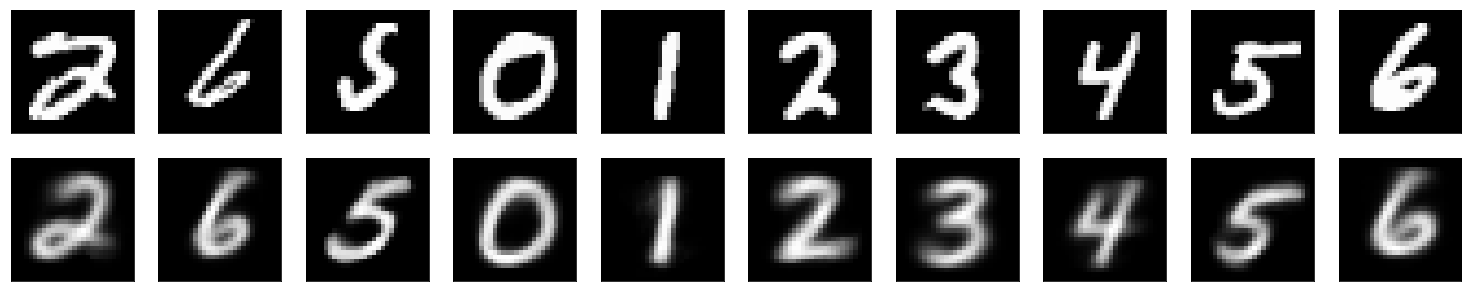

In [55]:
# display original and reconstructed images, in rows
display_images(images, reconstructions)

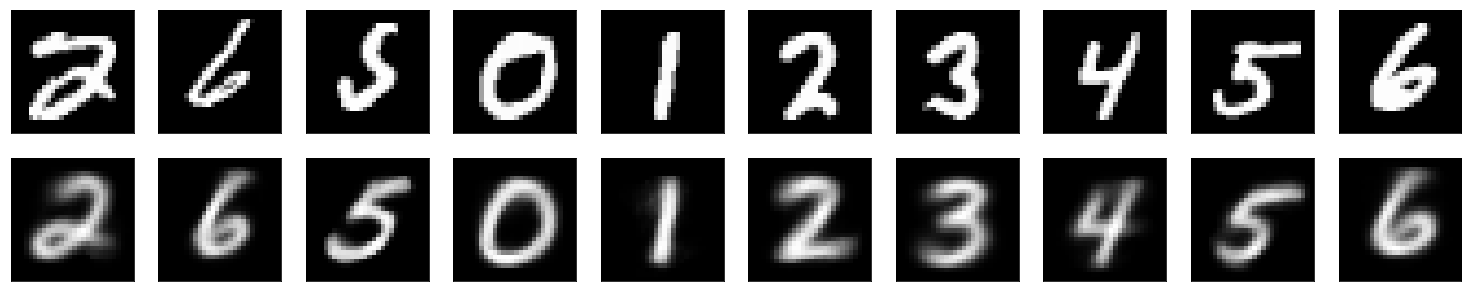

In [57]:
# display original and reconstructed images, in rows
display_images(images, reconstructions)

---
## 对仿射变换的响应

在 [胶囊网络论文](https://arxiv.org/pdf/1710.09829.pdf) 中，他们有一个部分比较了胶囊网络和普通 CNN 的性能。一个观察结果是，胶囊网络对数据的仿射变换更加鲁棒。也就是说，即使网络是在正常的 MNIST 数据上训练的，如果你然后平移或旋转一些测试数据，经过训练的 CapsNet 将比普通 CNN 表现得更好。

从论文：
> 实验表明，与传统的卷积网络相比，每个 DigitCaps 胶囊为每个类别学习更稳健的表示。由于手写数字的倾斜、旋转、样式等存在自然差异，因此经过训练的 CapsNet 对训练数据的小仿射变换具有中等鲁棒性。

他们创建仿射变换测试数据的过程与我的不同，但我想看看我训练的胶囊网络在随机仿射变换数据上的表现如何。下面，我正在应用仿射变换，该变换将在 0-30 度之间随机旋转和图像，并将图像垂直/水平平移 10% 的图像总高度/宽度。

In [58]:
# convert data to Tensor *and* perform random affine transformation
transform = transforms.Compose(
    [transforms.RandomAffine(degrees=30, translate=(0.1,0.1)),
     transforms.ToTensor()]
    )

# test dataset
transformed_test_data = datasets.MNIST(root='data', train=False,
                                       download=True, transform=transform)

# prepare data loader
transformed_test_loader = torch.utils.data.DataLoader(transformed_test_data, 
                                                      batch_size=batch_size,
                                                      num_workers=num_workers)

### 可视化转换后的数据

可以看到这个测试数据已经随机旋转和平移了。

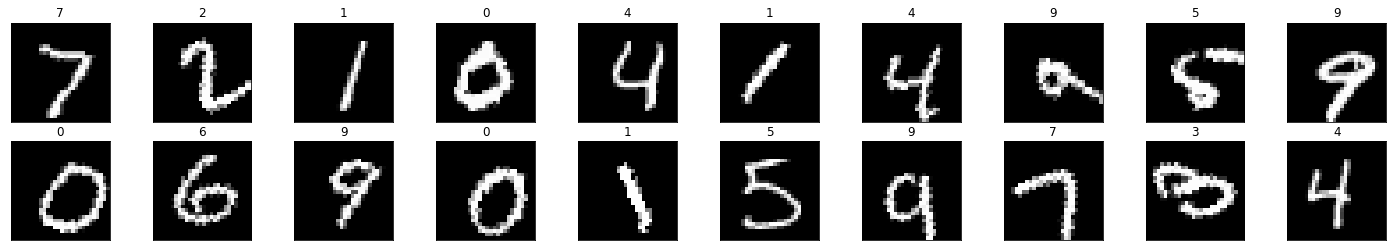

In [59]:
# obtain one batch of test images
dataiter = iter(transformed_test_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

### 对转换后的测试数据进行测试

In [62]:
# call test function and get reconstructed images
_, images, reconstructions = test(capsule_net, transformed_test_loader)

Test Loss: 0.30448733

Test Accuracy of     0: 88% (864/980)
Test Accuracy of     1: 83% (945/1135)
Test Accuracy of     2: 84% (868/1032)
Test Accuracy of     3: 80% (808/1010)
Test Accuracy of     4: 77% (763/982)
Test Accuracy of     5: 88% (793/892)
Test Accuracy of     6: 82% (790/958)
Test Accuracy of     7: 84% (864/1028)
Test Accuracy of     8: 73% (717/974)
Test Accuracy of     9: 74% (747/1009)

Test Accuracy (Overall): 81% (8159/10000)


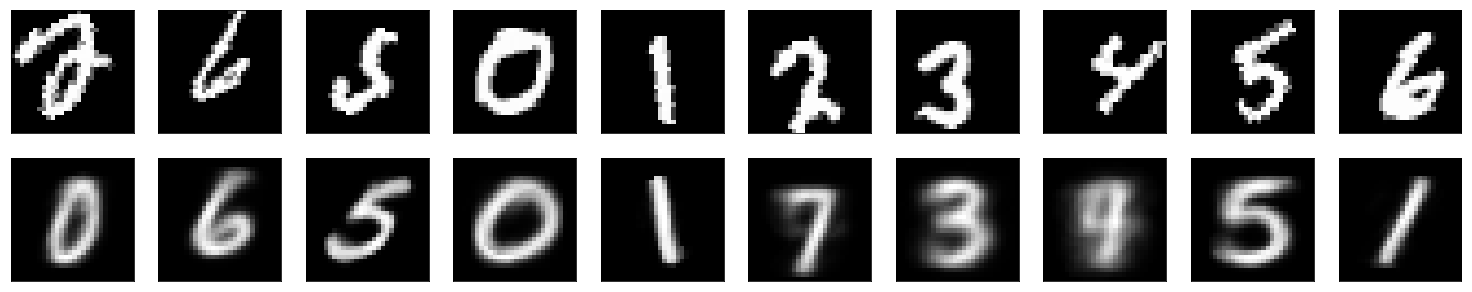

In [64]:
# original input images
display_images(images, reconstructions)

## 胶囊输出向量

回想一下‘DigitCaps’层输出dim 16的向量。事实证明，这些向量维度中的一些已经了解了构成每个数字的特征。从论文：
> 由于我们只传递一位数字的编码并将其他数字归零，因此数字胶囊的维度应该学习跨越该类数字实例化方式的变化空间。
这些变化包括笔画粗细、倾斜和宽度。它们还包括特定于数字的变体
例如a 2 的尾部长度。**我们可以通过制作来了解各个维度代表什么
使用解码器网络**。

以下是该论文的一些有趣发现：

<img src='assets/perturbed_reconstructions.png' width=70% />

他们的方法是计算“正确”数字胶囊的输出向量，然后通过*扰动*它来修改 16 个向量维度中的每一个；在`[-0.25, 0.25]`范围内添加一些小值，乘以`0.05`。我尝试在下面复制这个实验，看看我是否能找到与数字宽度、线宽、倾斜或某些局部特征相对应的某个向量维度！

In [70]:
def vector_analysis(capsule_net, x, select_idx=1):
    '''Generates perturbed iage reconstructions given some digit capsule outputs.
       param capsule_net: trained capsule network
       param x: a batch of digit capsule outputs
       param select_idx: selects which image in a batch to analyze, default = 1 
       return: list of perturbed, reconstructed images
       '''
    
    classes = (x ** 2).sum(dim=-1) ** 0.5
    classes = F.softmax(classes, dim=-1)

    # find the capsule with the maximum vector length
    # here, vector length indicates the probability of a class' existence
    _, max_length_indices = classes.max(dim=1)

    # create a sparse class matrix
    sparse_matrix = torch.eye(10) # 10 is the number of classes
#     if TRAIN_ON_GPU:
#         sparse_matrix = sparse_matrix.cuda()
    # get the class scores from the "correct" capsule
    y = sparse_matrix.index_select(dim=0, index=max_length_indices.data)

    # create reconstructed pixels
    x = x * y[:, :, None]
    
    # flatten image into a vector shape (batch_size, vector_dim)
    flattened_x = x.reshape(x.size(0), -1)
    # select a single image from a batch to work with
    flattened_x = flattened_x[select_idx]
    
    # track reconstructed images
    reconstructed_ims = []
    # values to change *one* vector dimension by
    perturb_range = np.arange(-0.25, 0.30, 0.05)
    
    # iterate through 16 vector dims
    for k in range(16):
        # create a copy of flattened_x to modify
        transformed_x = torch.zeros(*flattened_x.size())
        transformed_x[:] = flattened_x[:]
        # iterate through each perturbation value
        for j in range(len(perturb_range)):
            # for each capsule output
            for i in range(10):
                transformed_x[k+(16*i)] = flattened_x[k+(16*i)]+perturb_range[j]

            # create reconstructed images
            reconstructions = capsule_net.decoder.linear_layers(transformed_x)
            # reshape into 28x28 image, (batch_size, depth, x, y)
            reconstructions = reconstructions.view(-1, 1, 28, 28)
            reconstructed_ims.append(reconstructions)
    
    # return final list of reconstructed ims    
    return reconstructed_ims
        

In [71]:
# call function and get perturbed reconstructions
reconstructed_ims = vector_analysis(capsule_net, caps_output, select_idx=1)

## 显示重建

中心图像应为原始重建图像； 左边的五个图像有负扰动，右边有 5 个图像有正扰动。

* 有 16 行图像，每个向量维度对应一个图像
* 每行有 11 张图片，上面定义的 `perturb_range` 中的每个值对应一张图片

您应该看到某些矢量暗度对应于某些图像属性； 线宽、倾斜、局部特征等！ 如果您在本地运行此代码，我鼓励您尝试在批处理中对不同的图像进行瘦身（使用不同的 `select_idx`）并检查结果。

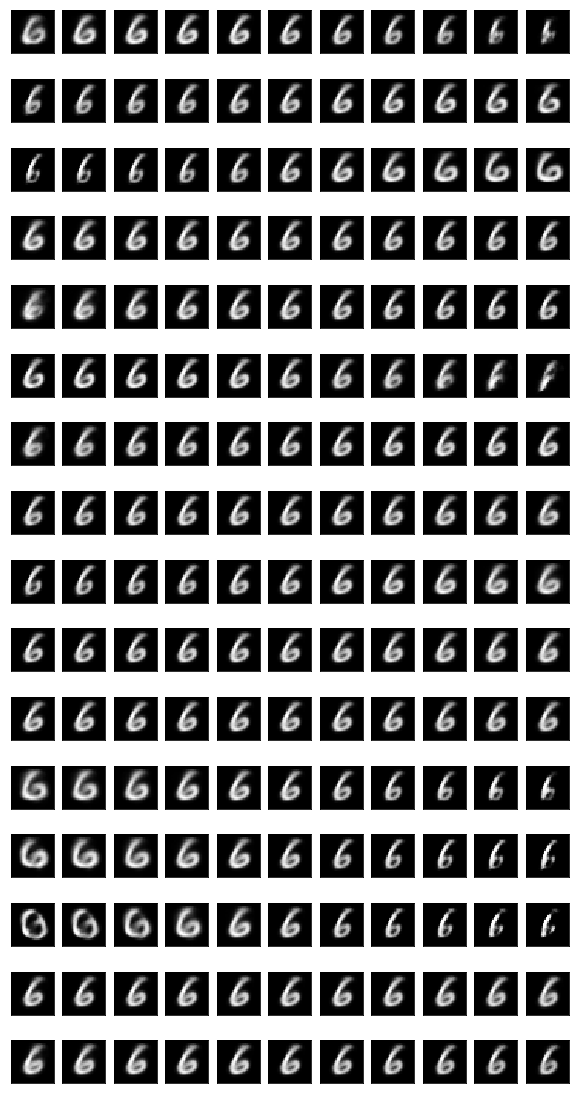

In [73]:
fig = plt.figure(figsize=(10, 20)) # define figsize

# display all ims
for idx in range(len(reconstructed_ims)):
    # convert to numpy images
    image = reconstructed_ims[idx]
    image = image.detach().cpu().numpy()
    # display 16 rows of images
    ax = fig.add_subplot(16, len(reconstructed_ims)/16, idx+1, xticks=[], yticks=[])
    ax.imshow(image.squeeze(), cmap='gray')